# Analyzing dropsonde-measured thermodynamics

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cape_cin
import xarray as xr
import datetime
# increase font size
plt.rcParams.update({"font.size": 16})
# for calculating saturated vapor mixing ratio
sys.path.append('/glade/u/home/rberrios/projects/ASD2022-2023/')
from functions_mpas import RSLF

In [2]:
def replace_negative_9999_with_nan(df):
  """
  Replaces all occurrences of -9999.0 with NaN in a pandas DataFrame.

  Args:
    df: The input pandas DataFrame.

  Returns:
    A new pandas DataFrame with -9999.0 replaced by NaN.
  """
  return df.replace(-9999.0, np.nan)

def calc_qv_from_dropsondes(df):
    qvs = RSLF(df.Pressure.values*100.0,df.Temperature.values+273.15)
    qv = df.RH.values*0.01*qvs

    return qv


def read_filter_dropsonde_data(fname):
    df = pd.read_csv(fname, skiprows=123)
    # define label for this dropsonde
    label = fname[62:64]+":"+fname[64:66]

    # eliminate points where there's no temp and no dew point
    # df = df[(df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Pressure >= 100.0) &
    #         (df.Uwnd != -9999.0) & (df.Vwnd != -9999.0)]
    df = replace_negative_9999_with_nan(df)

    # calculate qv from RH, temperature, and pressure
    qv = calc_qv_from_dropsondes(df)
    df['Qv'] = qv

    #smooth out with downsampling by pressure
    p_bins = np.arange(200,1000,10)
    dfGrouped = df.groupby(pd.cut(df.Pressure,p_bins)).mean()

    return dfGrouped

def get_binned_row_by_pressure(df_binned, target_pressure):
    """
    Finds the row in a binned DataFrame corresponding to a target pressure level.

    Args:
        df_binned (pd.DataFrame): The DataFrame with an IntervalIndex representing pressure bins.
        target_pressure (float or int): The pressure level to search for.

    Returns:
        pd.DataFrame: A DataFrame containing the row that includes the target pressure,
                      or an empty DataFrame if no such bin is found.
    """
    found_row = pd.DataFrame() # Initialize as an empty DataFrame

    for interval_idx, row_data in df_binned.iterrows():
        # Check if the target_pressure falls within the current bin interval
        if target_pressure in interval_idx:
            # Convert the Series (row_data) back to a DataFrame row
            found_row = row_data.to_frame().T
            break # Stop once the first matching bin is found

    return found_row

Get list of dropsonde files.

In [3]:
date = "20220914"
dropFiles = [f for f in sorted(glob.glob("CPEXCV-dropsonde_DC8_%s_R0/CPEXCV-dropsonde*ict"%date, recursive=True))]
dropFiles

['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914100038_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914101158_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914104056_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914105739_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914113501_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914114500_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914115120_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914120116_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914121728_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914122949_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914125042_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914130420_R0.ict',
 'CPEXCV-dropsonde_DC8_20220914_R0/CPEXC

Get full flight info.

In [4]:
navFile = '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/CPEXCV-MetNav_DC8_20220914_R0.ict'
df = pd.read_csv(navFile,skiprows=75)
df

,Time_Start,Day_Of_Year,Latitude,Longitude,MSL_GPS_Altitude,HAE_GPS_Altitude,Pressure_Altitude,Radar_Altitude,Ground_Speed,True_Air_Speed,...,Wind_Direction,Solar_Zenith_Angle,Aircraft_Sun_Elevation,Sun_Azimuth,Aircraft_Sun_Azimuth,Mixing_Ratio,Part_Press_Water_Vapor,Sat_Vapor_Press_H2O,Sat_Vapor_Press_Ice,Relative_Humidity
0,34142,257,16.724665,-22.948866,74,-9999,153,4.0,0.13,-8888.0,...,-9999.0,60.2,29.9,95.8,96.7,21.21,33.23,36.53,47.46,90.95
1,34143,257,16.724678,-22.948866,74,-9999,155,3.5,0.51,-8888.0,...,359.5,60.2,29.9,95.8,96.8,21.41,33.52,36.53,47.46,91.76
2,34144,257,16.724701,-22.948866,74,-9999,155,4.5,1.22,-8888.0,...,359.2,60.2,30.0,95.8,96.9,21.60,33.82,36.53,47.46,92.58
3,34145,257,16.724735,-22.948866,74,-9999,157,4.0,2.12,-8888.0,...,359.1,60.2,30.1,95.8,97.1,22.04,34.49,36.53,47.46,94.40
4,34146,257,16.724787,-22.948866,73,-9999,160,4.5,3.34,-8888.0,...,359.0,60.2,30.2,95.8,97.3,22.26,34.81,36.53,47.46,95.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25778,59920,257,16.742817,-22.947048,72,-9999,180,3.5,4.95,-8888.0,...,-9999.0,48.6,41.1,-100.8,127.0,-9999.00,-9999.00,38.72,50.78,-9999.00
25779,59921,257,16.742779,-22.947031,72,-9999,180,3.5,4.76,-8888.0,...,307.8,48.6,41.2,-100.8,120.0,-9999.00,-9999.00,38.72,50.78,-9999.00
25780,59922,257,16.742741,-22.947018,72,-9999,180,3.5,4.69,-8888.0,...,320.0,48.6,41.1,-100.8,113.8,-9999.00,-9999.00,38.72,50.78,-9999.00
25781,59923,257,16.742701,-22.947008,72,-9999,181,3.5,4.57,-8888.0,...,327.8,48.6,41.2,-100.8,108.3,-9999.00,-9999.00,39.29,51.64,-9999.00


Plot the whole file track and dropsonde locations.

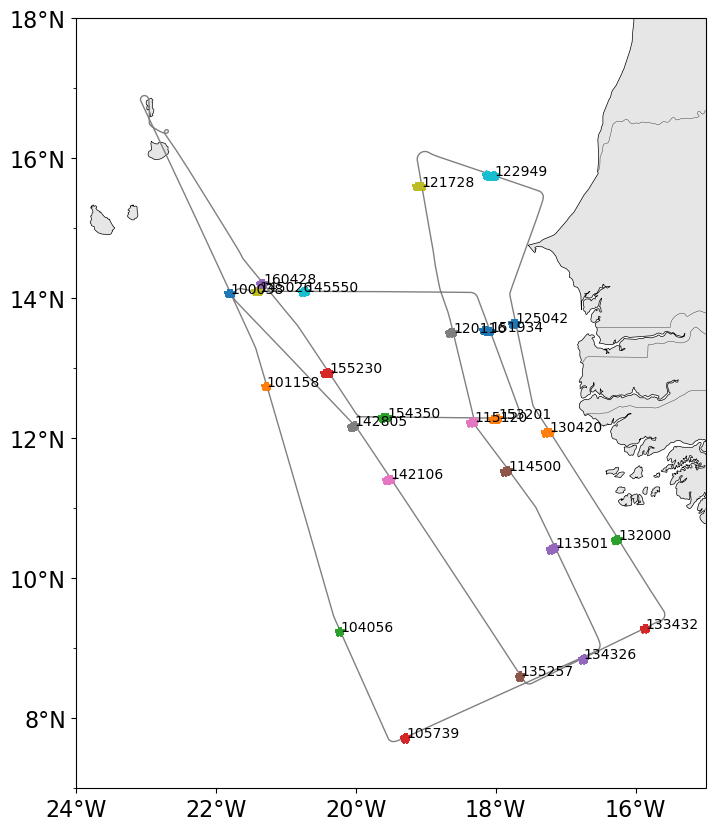

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Create a figure and axis using the Plate Carree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, figsize=[15,10])

# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.25)
ax.add_feature(cfeature.LAND, facecolor='0.90')

# Set the x and y axis limits
minLat = 7
maxLat = 18
minLon = -24
maxLon = -15
lat_interval = 2.0
lon_interval = 2.0
ax.set_extent([minLon, maxLon, minLat, maxLat], ccrs.PlateCarree()) 

# Add Latitudes
ax.set_yticks(np.arange(minLat, maxLat, lat_interval), ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add Longitudes
ax.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)

# flight track
navFile = '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/CPEXCV-MetNav_DC8_20220914_R0.ict'
df = pd.read_csv(navFile,skiprows=75)
ax.plot(df.Longitude, df.Latitude, color='gray', linewidth=1)
del(df)

for fname in dropFiles:
    drop_time = fname[62:68]
    # read dropsonde data as a data frame
    df = pd.read_csv(fname,skiprows=123)

    # eliminate points where there's no temp and no dew point
    df = df[ (df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Pressure >= 100.0) &
        (df.Latitude != -9999.0)]

    ax.plot(df.Longitude,df.Latitude,'*')
    ax.text(df.Longitude.iloc[0],df.Latitude.iloc[0],drop_time,fontsize=10)

In [6]:
dropsGrouped = {
    'north': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
                    for i in [100038,122949,130420,132000]],
    'south': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
                    for i in [104056,132000]],
    'middle': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
                    for i in [100038,130420]],
    'samePoint':['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [100038,145026]],
    'samePointPM':['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [145026, 160428]],
    'jet': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [121728,122949]],
    'convection': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [145550,160428]],
    'coldPool1': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [100038,120116]],
    'coldPool2': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [100038,145550]],
    'coldPool3': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [100038,160428]],
    'coldPools': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [100038,120116,145550,160428]],
    'convergence': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [104056, 113501]],
    'holger': ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
            for i in [135257, 142106]],
}

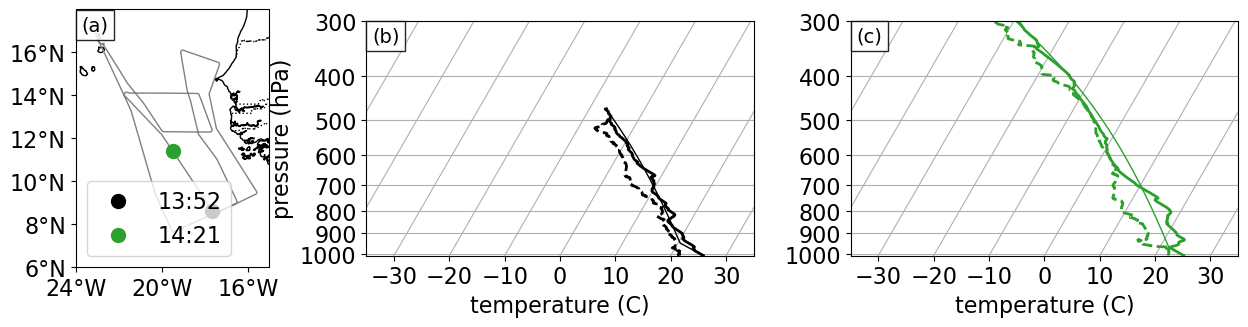

In [7]:
import metpy.calc as mpcalc
from metpy.units import units
import metpy.plots as mpp
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

region = 'holger'
plotWinds = False

# Set the x and y axis limits for the map
minLat = 6.0
maxLat = 18.0
minLon = -24
maxLon = -15
lat_interval = 2.0
lon_interval = 4.0

lineColors = ['k', 'tab:green', 'tab:pink']
dropsToCompare = dropsGrouped[region]

# Determine the number of data files
num_dropsondes = len(dropsToCompare)

# Adjust the number of columns in the grid
num_rows = 1
num_cols = 3
num_panels = num_rows * num_cols

fig = plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size as needed
gs = fig.add_gridspec(num_rows, num_cols, hspace=0.3, wspace=0.3, width_ratios=[1,2,2]) # Create grid specification

# Add the map panel to the first column
ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax_map.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.PlateCarree()) # Set zoomed-in extent
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.BORDERS, linestyle=':')

# Add Latitudes
ax_map.set_yticks(np.arange(minLat, maxLat, lat_interval), crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter() # Assuming mpp is metpy.plots, which contains LatitudeFormatter
ax_map.yaxis.set_major_formatter(lat_formatter)

# Add Longitudes
ax_map.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True) # Assuming mpp is metpy.plots, which contains LongitudeFormatter
ax_map.xaxis.set_major_formatter(lon_formatter)


# ax_map.set_title('Dropsonde Locations')
# flight track
navFile = '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/CPEXCV-MetNav_DC8_20220914_R0.ict'
df = pd.read_csv(navFile,skiprows=75)
ax_map.plot(df.Longitude, df.Latitude, color='gray', linewidth=1)
del(df)

# List of axes to label
axes_to_label = [ax_map]

for i in range(num_dropsondes):
    # Get the SubplotSpec for the current Skew-T panel
    subplot_spec = gs[0, i + 1]  # Skew-Ts are in the second and third columns

    # Create a Skew-T axes object directly, specifying the subplot
    skew = mpp.SkewT(fig, subplot=subplot_spec)

    # Now 'skew.ax' is the Skew-T Axes object you can work with
    ax = skew.ax  # Access the Skew-T's underlying Axes object
    axes_to_label.append(ax)

    fname = dropsToCompare[i]
    # read dropsonde data as a data frame
    df = pd.read_csv(fname, skiprows=123)
    # define label for this dropsonde
    label = fname[62:64]+":"+fname[64:66]

    # eliminate points where there's no temp and no dew point
    df = df[(df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Pressure >= 100.0) &
            (df.Uwnd != -9999.0) & (df.Vwnd != -9999.0)]
    # Add units
    p = df['Pressure'][::-1].values * units.hPa
    T = df['Temperature'][::-1].values * units.degC
    Td = df['Dewpoint'][::-1].values * units.degC
    u = df['Uwnd'][::-1].values * units('m/s')
    v = df['Vwnd'][::-1].values * units('m/s')

    # Calculate the parcel profile.
    parcel_prof = mpcalc.parcel_profile(p, T[1], Td[1]).to('degC')

    # Plot the environment and parcel
    skew.plot(p, T, linewidth=2, color=lineColors[i])
    skew.plot(p, Td, '--', linewidth=2, color=lineColors[i])
    skew.plot(p, parcel_prof, linewidth=1, color=lineColors[i])

    # Shade areas of CAPE and CIN
    # skew.shade_cin(p, T, parcel_prof, Td)
    # skew.shade_cape(p, T, parcel_prof)

    if (plotWinds):
        # plot the winds
        # make sure to eliminate missing data
        u_valid = u[u != -9999.0]
        v_valid = v[v != -9999.0]
        p_valid = p[~((u == -9999.0) | (v == -9999.0))] # Ensure pressure matches valid wind data
        skew.plot_barbs(p_valid[::50], u_valid[::50], v_valid[::50], length=6)

    if (i > 0):
        ax.set_ylabel('')
    else:
        ax.set_ylabel('pressure (hPa)')
    ax.set_xlabel('temperature (C)')
    # ax.set_title(label)
    ax.set_xlim(-35,35)
    ax.set_ylim(1010,300)

    # Plot the dropsonde location on the map
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        latitude = df['Latitude'].iloc[0]
        longitude = df['Longitude'].iloc[0]
        ax_map.plot(longitude, latitude, 'o', color=lineColors[i], markersize=10, transform=ccrs.PlateCarree(), label=label)

# Add a legend to the map
ax_map.legend(loc='lower left')

for j, axis in enumerate(axes_to_label):
    label = f"({chr(j+97)})"
    if (j == 0):
        xd = 0.03
    else:
        xd = 0.015
    axis.text(xd, 0.975, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='14', bbox=dict(facecolor='white', alpha=0.85))
    
# plt.savefig('./Figures/dropsonde_comparison_%s.jpeg'%region,bbox_inches='tight',dpi=300)

### Just wind profiles -- checking hypothesis that wind profile is different near the coast vs over water

/glade/derecho/scratch/rberrios/tmp/ipykernel_68235/3117637111.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfGrouped = df.groupby(pd.cut(df.Pressure,p_bins)).mean()
/glade/derecho/scratch/rberrios/tmp/ipykernel_68235/3117637111.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfGrouped = df.groupby(pd.cut(df.Pressure,p_bins)).mean()
/glade/derecho/scratch/rberrios/tmp/ipykernel_68235/3117637111.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

[4.17215208]
[0.0011331] [0.01507697]
****
-11.82913043478261 -1.6294444444444443
drop location: 14.07, -21.78
[22.6994325]
[0.00335664] [0.01015523]
****
-26.518947368421053 4.388125
drop location: 15.75, -18.02
[21.18524376]
[0.00474486] [0.01553765]
****
-25.790588235294116 4.316111111111111
drop location: 12.09, -17.23
[9.35766878]
[0.00493474] [0.01193486]
****
-20.669473684210526 1.3070588235294116
drop location: 10.56, -16.25


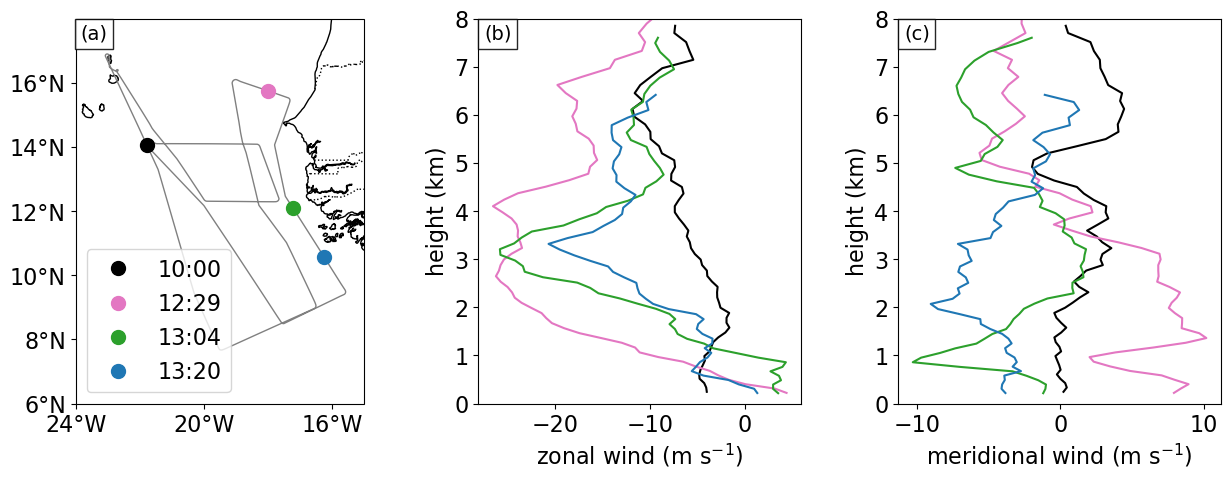

In [42]:
import metpy.calc as mpcalc
from metpy.units import units
import metpy.plots as mpp
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set the x and y axis limits for the map
minLat = 6.0
maxLat = 18.0
minLon = -24
maxLon = -15
lat_interval = 2.0
lon_interval = 4.0

region = 'north'
dropsToCompare = dropsGrouped[region]
lineColors = ['k','tab:pink', 'tab:green','tab:blue','tab:brown']

# Determine the number of data files
num_dropsondes = len(dropsToCompare)

# Adjust the number of columns in the grid
num_rows = 1
num_cols = 3
num_panels = num_rows * num_cols

fig = plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size as needed
gs = fig.add_gridspec(num_rows, num_cols, hspace=0.3, wspace=0.3) # Create grid specification

# Add the map panel to the first column
ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax_map.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.PlateCarree()) # Set zoomed-in extent
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.BORDERS, linestyle=':')
# ax_map.set_xticks(range(int(minLon), int(maxLon) + 1, int(lon_interval)), crs=ccrs.PlateCarree())
# ax_map.set_yticks(range(int(minLat), int(maxLat) + 1, int(lat_interval)), crs=ccrs.PlateCarree())

# Add Latitudes
ax_map.set_yticks(np.arange(minLat, maxLat, lat_interval), crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter() # Assuming mpp is metpy.plots, which contains LatitudeFormatter
ax_map.yaxis.set_major_formatter(lat_formatter)

# Add Longitudes
ax_map.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True) # Assuming mpp is metpy.plots, which contains LongitudeFormatter
ax_map.xaxis.set_major_formatter(lon_formatter)

# flight track
navFile = '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/CPEXCV-MetNav_DC8_20220914_R0.ict'
df = pd.read_csv(navFile,skiprows=75)
ax_map.plot(df.Longitude, df.Latitude, color='gray', linewidth=1)
del(df)

# Get the SubplotSpec for the current Skew-T panel
subplot_spec = gs[0, 1]  # Skew-Ts are in the second and third columns
ax1 = fig.add_subplot(subplot_spec)
subplot_spec = gs[0, 2]  # Skew-Ts are in the second and third columns
ax2 = fig.add_subplot(subplot_spec)

for i in range(num_dropsondes):
    # read dropsonde
    fname = dropsToCompare[i]
    # define label for this dropsonde
    label = fname[62:64]+":"+fname[64:66]
    # read dropsonde data as a data frame
    df = read_filter_dropsonde_data(fname)
    # Add units
    z = df['Altitude'][::-1].values

    # --- get shear
    row650 = get_binned_row_by_pressure(df, 650)
    row950 = get_binned_row_by_pressure(df, 950)
    uShear = row650['Uwnd'].values-row950['Uwnd'].values
    vShear = row650['Vwnd'].values-row950['Vwnd'].values
    shrmag = (uShear**2.0 + vShear**2.0)**0.5
    print(shrmag)
    # --- get qv at 500 hPa and 925 hPa
    qv500 = get_binned_row_by_pressure(df, 500)['Qv'].values
    qv925 = get_binned_row_by_pressure(df, 925)['Qv'].values
    print(qv500, qv925)

    # plot
    if (region == 'coldPools'):
        T = df['Temperature'][::-1].values
        RH = df['RH'][::-1].values
        ax1.plot(T[0:15],z[0:15],color=lineColors[i])
        ax2.plot(RH[0:15],z[0:15],color=lineColors[i])
    else:
        u = df['Uwnd'][::-1].values * units('m/s')
        print('****')
        print(df['Uwnd'].min(), df['Uwnd'].max())
        v = df['Vwnd'][::-1].values * units('m/s')
        # ax.plot(u,v,color=lineColors[i])
        ax1.plot(u,z*1.0e-3,color=lineColors[i])
        ax2.plot(v,z*1.0e-3,color=lineColors[i])

    # Plot the dropsonde location on the map
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        latitude = df['Latitude'].dropna().iloc[0]
        longitude = df['Longitude'].dropna().iloc[0]
        print('drop location: %2.2f, %2.2f'%(latitude,longitude))
        ax_map.plot(longitude, latitude, 'o', color=lineColors[i], markersize=10, transform=ccrs.PlateCarree(), label=label)

# Add a legend to the map
ax_map.legend()
# Add a panel label to the map


# Add labels to the line plot
if (region == 'coldPools'):
    ax1.set_ylabel('height (m)')
    ax1.set_xlabel('temperature ($^{\circ}$C)')
    ax2.set_ylabel('height (m)')
    ax2.set_xlabel('relative humidity (%)')
else:
    ax1.set_ylabel('height (km)')
    ax1.set_xlabel('zonal wind (m s$^{-1}$)')
    ax2.set_ylabel('height (km)')
    ax2.set_xlabel('meridional wind (m s$^{-1}$)')
    ax1.set_ylim([0,8])
    ax2.set_ylim([0,8])

# Add panel labels
# List of axes to label
axes_to_label = [ax_map, ax1, ax2]

for j, axis in enumerate(axes_to_label):
    label = f"({chr(j+97)})"
    axis.text(0.018, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='14', bbox=dict(facecolor='white', alpha=0.85))

plt.tight_layout()
plt.savefig('./Figures/dropsonde_comparison_%s.jpeg'%region,bbox_inches='tight',dpi=300)

### Looking at vertical velocity from dropsondes

In [ ]:
#region = 'samePointPM'
#dropsToCompare = dropFiles[-30:-20]#dropsGrouped[region]
# dropsToCompare = ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
#                     for i in [104056,125042,133432,134326,145550,160428]]
dropsToCompare = dropsGrouped['convection']


# in cloud but with w outside +-1 m/s: 113501,120116,

# Determine the number of data files
num_dropsondes = len(dropsToCompare)

plt.figure(figsize=(6,5))

for i in range(num_dropsondes):

    fname = dropsToCompare[i]
    # read dropsonde data as a data frame
    df = pd.read_csv(fname, skiprows=123)
    # define label for this dropsonde
    label = fname[62:64]+":"+fname[64:66]

    # eliminate points where there's no temp and no dew point
    df = df[(df.Pressure >= 100.0) &
            (df.Uwnd != -9999.0) & (df.Vwnd != -9999.0) & (df.Wwnd != -9999.0)]

    plt.plot(df.Wwnd,df.Altitude*1e-3,label=label)
plt.legend()
plt.ylim(0,13)
plt.grid()
plt.ylabel('height (km)')
plt.xlabel('dropsonde vertical velocity (m s$^{-1}$)')
plt.savefig('./Figures/dropsonde_vertical_velocity_convection.jpeg',bbox_inches='tight',dpi=150)

In [ ]:
df

### Attempt to compute divergence and vertical velocity

In [ ]:
import metpy.calc as mpcalc
from metpy.units import units
import metpy.plots as mpp
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

dropNorth = 122949
dropSouth = 114500
dropEast = 120116
dropWest = 125042

dropsToCompare = ['CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914%i_R0.ict'%i \
                    for i in [dropNorth, dropSouth, dropWest, dropEast]]
print(dropsToCompare[1])

lineColors = ['tab:pink', 'tab:green', 'tab:blue', 'brown']


# Set the x and y axis limits for the map
minLat = 7.5
maxLat = 17
minLon = -24
maxLon = -15
lat_interval = 2.0
lon_interval = 2.0

# Determine the number of data files
num_dropsondes = len(dropsToCompare)

# Adjust the number of columns in the grid
num_rows = 1
num_cols = 5
num_panels = num_rows * num_cols

fig = plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size as needed
gs = fig.add_gridspec(num_rows, num_cols, hspace=0.3, wspace=0.3) # Create grid specification

# Add the map panel to the first column
ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax_map.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.PlateCarree()) # Set zoomed-in extent
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.BORDERS, linestyle=':')
ax_map.set_xticks(range(int(minLon), int(maxLon) + 1, int(lon_interval)), crs=ccrs.PlateCarree())
ax_map.set_yticks(range(int(minLat), int(maxLat) + 1, int(lat_interval)), crs=ccrs.PlateCarree())
ax_map.set_title('Dropsonde Locations')
# flight track
navFile = '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/CPEXCV-MetNav_DC8_20220914_R0.ict'
df = pd.read_csv(navFile,skiprows=75)
ax_map.plot(df.Longitude, df.Latitude, color='gray', linewidth=1)
del(df)

for i in range(num_dropsondes):
    # Get the SubplotSpec for the current Skew-T panel
    subplot_spec = gs[0, i + 1]  # Skew-Ts are in the second and third columns

    # Create a Skew-T axes object directly, specifying the subplot
    skew = mpp.SkewT(fig, subplot=subplot_spec)

    # Now 'skew.ax' is the Skew-T Axes object you can work with
    ax = skew.ax  # Access the Skew-T's underlying Axes object

    fname = dropsToCompare[i]
    print(fname)
    # read dropsonde data as a data frame
    df = pd.read_csv(fname, skiprows=123)
    # define label for this dropsonde
    label = fname[62:64]+":"+fname[64:66]

    # eliminate points where there's no temp and no dew point
    df = df[(df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Pressure >= 100.0) &
            (df.Uwnd != -9999.0) & (df.Vwnd != -9999.0)]
    # Add units
    p = df['Pressure'][::-1].values * units.hPa
    T = df['Temperature'][::-1].values * units.degC
    Td = df['Dewpoint'][::-1].values * units.degC
    u = df['Uwnd'][::-1].values * units('m/s')
    v = df['Vwnd'][::-1].values * units('m/s')

    # Calculate the parcel profile.
    parcel_prof = mpcalc.parcel_profile(p, T[1], Td[1]).to('degC')

    # Plot the environment and parcel
    skew.plot(p, T, linewidth=2, color='k')
    skew.plot(p, Td, '--', linewidth=2, color='k')
    skew.plot(p, parcel_prof, color='k', linewidth=1)

    # Shade areas of CAPE and CIN
    skew.shade_cin(p, T, parcel_prof, Td)
    skew.shade_cape(p, T, parcel_prof)

    # plot the winds
    # make sure to eliminate missing data
    u_valid = u[u != -9999.0]
    v_valid = v[v != -9999.0]
    p_valid = p[~((u == -9999.0) | (v == -9999.0))] # Ensure pressure matches valid wind data

    skew.plot_barbs(p_valid[::50], u_valid[::50], v_valid[::50], length=4)

    if (i > 0):
        ax.set_ylabel('')
    else:
        ax.set_ylabel('pressure (hPa)')
    ax.set_xlabel('temperature (C)')
    ax.set_title(label)
    ax.set_xlim(-40,40)

    # Plot the dropsonde location on the map
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        latitude = df['Latitude'].iloc[0]
        longitude = df['Longitude'].iloc[0]
        ax_map.plot(longitude, latitude, 'o', color=lineColors[i], markersize=5, transform=ccrs.PlateCarree(), label=label)

# Add a legend to the map
ax_map.legend()

# plt.savefig('./Figures/dropsonde_comparison_%s.jpeg'%region,bbox_inches='tight',dpi=300)

In [ ]:
# Let's do it!
  
fname = dropsToCompare[0]
dfNorth = read_filter_dropsonde_data(fname)

fname = dropsToCompare[1]
dfSouth = read_filter_dropsonde_data(fname)

fname = dropsToCompare[2]
dfEast = read_filter_dropsonde_data(fname)

fname = dropsToCompare[3]
dfWest = read_filter_dropsonde_data(fname)

In [ ]:
Rearth = 6378e3
dudx = (dfWest.Uwnd - dfEast.Vwnd)/(Rearth*(np.radians(dfWest.Longitude)-np.radians(dfEast.Longitude)))
dvdy = (dfNorth.Vwnd - dfSouth.Vwnd)/(Rearth*(np.radians(dfNorth.Latitude)-np.radians(dfSouth.Latitude)))

In [ ]:
plt.figure()
plt.plot(dudx*1e5, dfNorth.Pressure)
plt.plot(dvdy*1e5, dfNorth.Pressure)
plt.plot( (dudx+dvdy)*1e5, dfNorth.Pressure, color='k', linewidth=2)
plt.ylim([1000,100])
plt.legend([r'$\frac{\partial u}{\partial x}$',
            r'$\frac{\partial v}{\partial y}$',
            r'total'])
plt.xlabel('divergence (10$^5$ s$^{-1}$)')
plt.ylabel('pressure (hPa)')
plt.grid(True)